In [9]:
import rasterio
from rasterio.plot import show
import numpy as np
import os
import glob

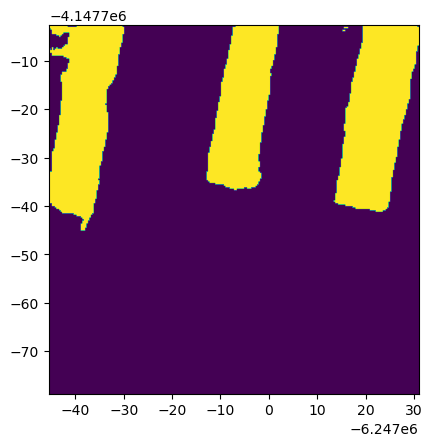

<Axes: >

In [3]:
image_path = "/home/annazan/fAIr-utilities/ramp-data/predictions/model97_td372/OAM-180416-316407-19.tif"


fp = r"/home/annazan/fAIr-utilities/ramp-data/predictions/model97_td372/OAM-180416-316407-19.tif"
img = rasterio.open(fp)
show(img)

In [2]:
import matplotlib.pyplot as plt

def visualise(image,reference,matched):
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, #figsize=(8, 3),
                                      sharex=True, sharey=True)
  for aa in (ax1, ax2, ax3):
      aa.set_axis_off()
  ax1.imshow(image)
  ax1.set_title('Source')
  ax2.imshow(reference, cmap='gray')
  ax2.set_title('Label')
  ax3.imshow(matched, cmap='winter')
  ax3.set_title('Prediction')
  plt.tight_layout()
  plt.show()


In [3]:
rgb_image = plt.imread("/home/annazan/fAIr-utilities/ramp-data/metric_data/model51_td364/train/pred-chips/OAM-312862-256652-19.tif")
# labels = plt.imread("/home/annazan/fAIr-utilities/ramp-data/metric_data/model51_td364/train/pred-labels/OAM-312862-256652-19.geojson")
mask = plt.imread("/home/annazan/fAIr-utilities/ramp-data/metric_data/model51_td364/train/pred-binarymasks/OAM-312862-256652-19.mask.tif")
prediction = plt.imread("/home/annazan/fAIr-utilities/ramp-data/predictions/nairobi5/OAM-315756-264006-19.tif")


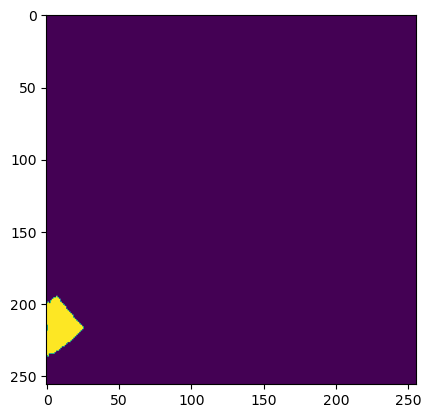

In [4]:
plt.imshow(prediction)

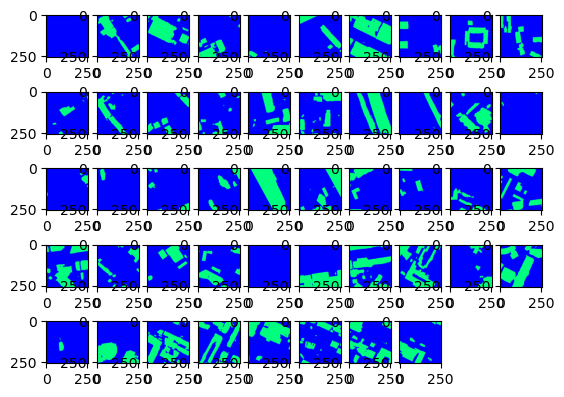

In [27]:
# little script to show all images in a folder
img_dir="/home/annazan/fAIr-utilities/ramp-data/predictions/nairobi5"
all_files=os.listdir(img_dir)
data_path = [os.path.join(img_dir + "/" + i) for i in all_files]
k=0
for i in data_path:
  k=k+1
  plt.subplot(5,5,k)
  imm= plt.imread(i)
  plt.imshow(imm, cmap='winter')
plt.show()

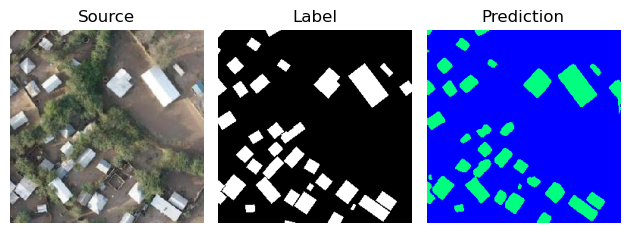

In [7]:
visualise(rgb_image,
          mask,
          prediction)

In [10]:
diff = abs(mask - prediction)

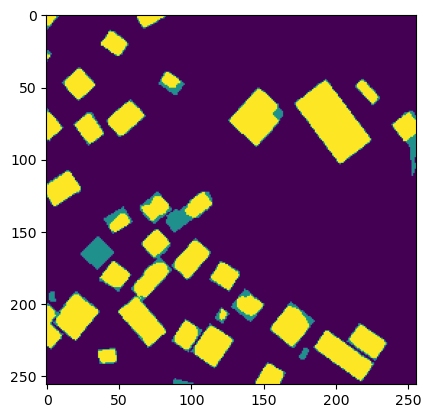

<Axes: >

In [11]:
show(diff)

In [12]:
diff.min()
diff.max()

2

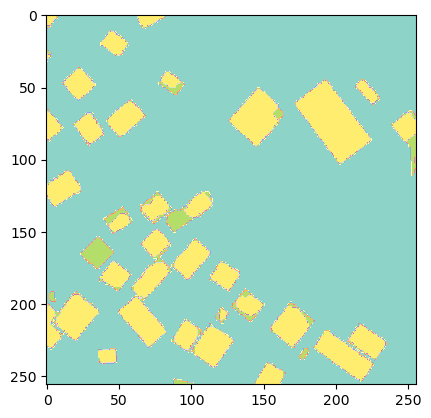

In [13]:
plt.imshow(diff,
       cmap='Set3')

In [14]:
def visualise_4plots(image,mask,infer, differ):
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(8, 4))
  for aa in (ax1, ax2, ax3, ax4):
      aa.set_axis_off()
  ax1.imshow(image)
  ax1.set_title('Source')
  ax2.imshow(mask,cmap='gray')
  ax2.set_title('Labels')
  ax3.imshow(infer,cmap='winter')
  ax3.set_title('Prediction')
  ax4.imshow(differ,cmap='hsv')
  ax4.set_title('Difference')
  plt.tight_layout()
  plt.show()

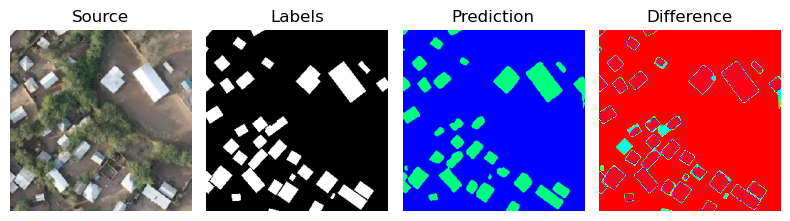

In [15]:
visualise_4plots(rgb_image,
                 mask,
                 prediction,
                 diff)

In [64]:
mask.shape

(256, 256)

In [65]:
prediction.shape

(256, 256)

In [66]:
type(mask)

numpy.ndarray

In [67]:
np.unique(mask)

array([0, 1], dtype=uint8)

In [68]:
np.unique(prediction)

array([  0, 255], dtype=uint8)

In [96]:
# Function to scale one image values to another range
# https://stackoverflow.com/questions/46689428/convert-np-array-of-type-float64-to-type-uint8-scaling-values
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [86]:
prediction01=convert(prediction,0,1,np.uint8)

In [87]:
np.unique(prediction01)

array([0, 1], dtype=uint8)

In [102]:
sparse_categorical_accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()

categorical_accuracy_fn = tf.keras.metrics.CategoricalAccuracy()

iou_fn = tf.keras.metrics.IoU(
        num_classes= 2,
        target_class_ids= [0, 1],
        name="iou")

# ohe_fn = tf.keras.metrics.OneHotIoU(
#         num_classes = 4,
#         name = "ohe_iou",
#         target_class_ids= [0, 1]
#         )

precision_fn = tf.keras.metrics.Precision(
        # E.g. buildings
        class_id=1,
        name="precision_1")

recall_fn = tf.keras.metrics.Recall(
        # E.g. buildings
        class_id=1,
        name="recall_1")

class F1_Score(tf.keras.metrics.Metric):
        #  from https://stackoverflow.com/a/64477522
        def __init__(self, class_id, name='f1_score', **kwargs):
                super().__init__(name=name, **kwargs)
                self.f1 = self.add_weight(name='f1', initializer='zeros')
                self.precision_fn = tf.keras.metrics.Precision(class_id=class_id)
                self.recall_fn = tf.keras.metrics.Recall(class_id=class_id)

        def update_state(self, y_true, y_pred, sample_weight=None):
                p = self.precision_fn(y_true, y_pred)
                r = self.recall_fn(y_true, y_pred)
                self.f1.assign(tf.math.divide_no_nan(2 * (p * r), (p + r)))

        def result(self):
                return self.f1

        def reset_states(self):
                # we also need to reset the state of the precision and recall objects
                self.precision_fn.reset_states()
                self.recall_fn.reset_states()
                self.f1.assign(0)

f1score_fn = F1_Score(class_id=1)

In [90]:
true_sample = mask[0]
pred_sample = prediction01[0]

In [100]:
IOU = iou_fn(mask,prediction01)

In [103]:
precision = precision_fn(mask,prediction01)

In [104]:
recall = recall_fn(mask, prediction01)

In [105]:
f1score = f1score_fn(mask,prediction01)

In [106]:
catacc = categorical_accuracy_fn(mask, prediction01)

In [101]:
IOU

<tf.Tensor: shape=(), dtype=float32, numpy=0.9005925>

In [114]:
catacc

<tf.Tensor: shape=(), dtype=float32, numpy=0.5703125>

In [91]:
pred_sample

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

---

In [71]:
def iou_metric(truth, pred, divide=False, eval_class=(1,)):
    """
    Compute IoU, i.e., jaccard index
    :param truth: truth data matrix, should be H*W
    :param pred: prediction data matrix, should be the same dimension as the truth data matrix
    :param divide: if True, will return the IoU, otherwise return the numerator and denominator
    :param eval_class: the label class to be evaluated
    :return:
    """
    truth = truth.flatten()
    pred = pred.flatten()
    iou_score = np.zeros((2, len(eval_class)), dtype=float)
    for c_cnt, curr_class in enumerate(eval_class):
        iou_score[0, c_cnt] += np.sum(((truth == curr_class) * (pred == curr_class)) == 1)
        iou_score[1, c_cnt] += np.sum(((truth == curr_class) + (pred == curr_class)) >= 1)
    if not divide:
        return iou_score
    else:
        return np.mean(iou_score[0, :] / iou_score[1, :])

In [74]:

iou = iou_metric(mask[0], prediction[0], divide=True)

In [75]:
iou

0.0





---



---

# Reference trials

In [ ]:
# From predict.py
# Standard library imports
import os
import time
from glob import glob
from pathlib import Path

# Third party imports
import numpy as np
from tensorflow import keras

from ..georeferencing import georeference
from ..utils import remove_files
from .utils import open_images, save_mask

BATCH_SIZE = 8
IMAGE_SIZE = 256
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [1]:
# Model import
# model = keras.models.load_model(checkpoint_path)
import tensorflow as tf

class F1_Score(keras.metrics.Metric):
    #  from https://stackoverflow.com/a/64477522
    def __init__(self, class_id, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision(class_id=classid)
        self.recall_fn = tf.keras.metrics.Recall(class_id=classid)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(tf.math.divide_no_nan(2 * (p * r), (p + r)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

def get_f1_score_fn():
    return F1_Score(class_id=1)


checkpoint_path = "/home/annazan/fAIr-utilities/ramp-data/metric_data/model97_td372/train/model-checkpts/20240514-214549/model_20240514-214549_020_0.970.tf"
model = keras.models.load_model(checkpoint_path,
                                # custom_objects={"F1_Score":F1_Score(class_id=1)},
                                custom_objects={"f1_score":get_f1_score_fn()},
                                compile=False)
# model.summary()
model.compile(metrics=['accuracy','f1_score','precision_1', 'recall_1', 'ohe_iou'])

model.evaluate()
...

NameError: name 'keras' is not defined